In [12]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"")); 
Pkg.instantiate()
using ForwardDiff
using Test

using LinearAlgebra
using StaticArrays
using Statistics
using Plots
using Printf
using JLD2

const FD = ForwardDiff;



  Activating environment at `~/Documents/ocrl_16745/legibility/Project.toml`
  Activating environment at `~/Documents/ocrl_16745/legibility/Project.toml`


# Point Model

In [13]:
x0    = [0.0, 0.0]                    # initial state
xgoal = [6.0, 5.0]                    # goal state
nx = 2 
nu = 2

Q = I(2)
R = I(2)
Qf = I(2) .* 10

dt = 0.025 
N = 61

61

61

# Helper Functions

In [14]:
function d(x1, y1, x2, y2)
    c = sqrt((x2 - x2)*(x2 - x1) + (y2 - y1)*(y2 - y1))
    return c
end

d (generic function with 1 method)

d (generic function with 1 method)

In [15]:

function dynamics(x,u)
    A = [1 0; 0 1]
    B = [1 0; 0 1]

    xnext = A * x + B*u
    return xnext
end


function rk4(x,u,dt)
    # rk4 for integration
    k1 = dt*dynamics(x,u)
    k2 = dt*dynamics(x + k1/2,u)
    k3 = dt*dynamics(x + k2/2,u)
    k4 = dt*dynamics(x + k3,u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end


function dynamics_jacobians(x,u,dt)
    # returns the discrete time dynamics jacobians
    A = FD.jacobian(_x -> rk4(_x,u,dt),x)
    B = FD.jacobian(_u -> rk4(x,_u,dt),u)
    return A,B
end

dynamics_jacobians (generic function with 1 method)

dynamics_jacobians (generic function with 1 method)

## LQR Cost Function

The objective / cost function for our optimization problem is of the following form:

$$\ell(x_{1:N}, u_{1:N-1}) = J_N(x_N) + \sum_{i=1}^{N-1} J(x_k,u_k) $$

Where the *stage cost* $J(x_k,u_k)$ is defined as:

$$J(x,u) = \frac{1}{2}(x - x_{ref})^TQ(x - x_{ref}) + \frac{1}{2}(u -u_{ref})^TR(u-u_{ref})$$

And the *terminal cost* is

$$J_N(x) = \frac{1}{2}(x - x_{ref})^TQ_f(x - x_{ref})$$

These cost functions penalize distance from a given reference trajectory. Quadratic cost functions of this form are often referred to as LQR costs.

## Legibility LQR Cost Function

Legibility is defined as 

$$\text{Legibility}(\xi) = \frac{\int P(G^*|\xi_{S \rightarrow \xi(t)}) f(t) dt} {\int f(t) dt}$$

When legibility is defined over an entire trajectory, $f(t) = T-t$ is a function to give more weight to earlier parts of a trajectory. 

$P(G^*|\xi_{S \rightarrow \xi(t)})$ is computed using a cost function $C$. $Z$ is a normalization term across all goals.

$$P(G^*|\xi_{S \rightarrow \xi(t)}) = \frac{1}{Z} \frac{exp(-C[\xi_{S \rightarrow Q}] - C[\xi^*_{Q \rightarrow G^*}])} {exp(-C[\xi_{S \rightarrow G^*}])} P(G)$$

The objective in generating legible trajectories is to maximize $\text{Legibility}(\xi)$.

$$ \underset{\xi}{\mathrm{argmax}} \text{ Legibility}(\xi) $$

Since we want a step-cost formulation for legibility, we define $f(t)=1$ and redefine legibility:

$$\text{Legibility}(\xi) = \sum_t P(G^*|\xi_{S \rightarrow \xi(t)}) = \sum_t \text{Legibility}(\xi_t)$$

Legibility at each timestep is 
$$\text{Legibility}(\xi_t) =  P(G^*|\xi_{S \rightarrow \xi(t)}) $$

$$ \underset{\xi}{\mathrm{argmax}} \text{ Legibility}(\xi) = \underset{\xi}{\mathrm{argmax}} P(G^*|\xi_{S \rightarrow \xi(t)}) $$

The trajectory that maximizes the probability of the intended goal $G^*$ also maximizes the log of the probability $\ln (P(G^*|\xi_{S \rightarrow \xi(t)}))$.

$$ \underset{\xi}{\mathrm{argmax}} P(G^*|\xi_{S \rightarrow \xi(t)}) = \underset{\xi}{\mathrm{argmax}} \ln(P(G^*|\xi_{S \rightarrow \xi(t)})) $$

We use a uniform prior $P(G)$ over goals and remove it from the objective.
$$ = \ln \left[ \frac{1}{Z} \frac{exp(-C[\xi_{S \rightarrow Q}] - C[\xi^*_{Q \rightarrow G^*}])} {exp(-C[\xi_{S \rightarrow G^*}])} \right] $$

$$ = \ln \left[ exp(-C[\xi_{S \rightarrow Q}] - C[\xi^*_{Q \rightarrow G^*}]) \right] - \ln \left[exp(-C[\xi_{S \rightarrow G^*}]) \right] - \ln(Z)$$

$$ = -C[\xi_{S \rightarrow Q}] - C[\xi^*_{Q \rightarrow G^*}]) + C[\xi_{S \rightarrow G^*}]) - \ln(Z)$$


## Redefined LQR Costs

The *stage legibility* $Legibility(x_k,u_k)$ is defined as:

$$Legibility(x_k,u_k) = -C[\xi_{S \rightarrow x_k}] - C[\xi^*_{x_k \rightarrow G^*}]) + C[\xi_{S \rightarrow G^*}]) - \ln(Z_k)$$

$$Legibility(x_k,u_k) = \frac{1}{2}(x_{start} - G^*)^TQ(x_{start} - G^*) - \frac{1}{2}(x_{start} - x_k)^TQ(x_{start} - x_k) - \frac{1}{2}(x_k - G^*)^TQ(x_k - G^*) - \ln(Z_k) $$

where 

$$Z = \sum_{G} P(G|\xi_{S \rightarrow \xi(t)})$$

The *stage cost* $J(x_k,u_k)$ is defined as:

$$J(x,u) = - Legibility(x_k,u_k) + \frac{1}{2}(u_k -u_{ref})^TR(u_k-u_{ref})$$


In [16]:

function stage_cost(x,u,xref,uref, start, goal1, all_goals, nongoal_scale)
    # Legibility LQR cost at each knot point (depends on both x and u)    

    goal_idx = 1    
    
    J_g1 = (start-goal1)'*Q*(start-goal1) - (start-x)'*Q*(start-x) +  - (x-goal1)'*Q*(x-goal1) 
    J_g1 *= 0.5

    log_sum = 0
    for i=1:length(all_goals)
        goal = all_goals[i]
        scale = 1
        if goal != goal1
            scale = nongoal_scale
        end
        n = - ((start-x)'*Q*(start-x) + 5) - ((x-goal)'*Q*(x-goal)+10)
        d = (start-goal)'*Q*(start-goal)
        log_sum += (exp(n )/exp(d))* scale

    end
    
    
    J = J_g1 - log(log_sum)

    J *= -1
    J += 0.5 *  (u-uref)'*R*(u-uref)

    return J
end


function term_cost(x,xref)
    # LQR terminal cost (depends on just x)
    J = 0.5*(x-xref)'*Qf*(x-xref)
    
    return J*1000
end


function trajectory_cost(X,U,Xref,Uref, start, goal1, all_goals, nongoal_scale)
    # calculate the cost of a given trajectory 
    N_len = length(Xref)
    J = term_cost(X[N_len],Xref[N_len])
    for i=1:length(Xref)-1
        xref = Xref[i]
        uref = Uref[i]
        x = X[i]
        u = U[i]
        J = J + stage_cost(x,u,xref,uref, start, goal1, all_goals, nongoal_scale)
    end
    return J
end
        
function stage_cost_expansion(x,u,xref,uref, start, goal1, all_goals, nongoal_scale)
    # if the stage cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ, ∇²ᵤJ, ∇ᵤJ

    Jxx = FD.hessian(dx -> stage_cost(dx,u,xref,uref, start, goal1, all_goals, nongoal_scale), x)
    Jx = FD.gradient(dx -> stage_cost(dx,u,xref,uref, start, goal1, all_goals, nongoal_scale), x)
        
    Juu = FD.hessian(du -> stage_cost(x,du,xref,uref, start, goal1, all_goals, nongoal_scale), u)
    Ju = FD.gradient(du -> stage_cost(x,du,xref,uref, start, goal1, all_goals, nongoal_scale), u)
        
    
    return Jxx, Jx, Juu, Ju
end

function term_cost_expansion(x,xref)
    # if the terminal cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ

    Jxx = FD.hessian(dx -> term_cost(dx, xref), x)
    Jx = FD.gradient(dx -> term_cost(dx, xref), x)
    
    return Jxx, Jx
end

term_cost_expansion (generic function with 1 method)

term_cost_expansion (generic function with 1 method)

## Backward Pass and Forward Pass


In [17]:

function backward_pass(X,U,Xref,Uref, start, goal1, all_goals, nongoal_scale)

    
    P = [zeros(nx,nx) for i = 1:N]     # cost to go quadratic term
    p = [zeros(nx) for i = 1:N]        # cost to go linear term 
    d = [zeros(nu)*NaN for i = 1:N-1]  # feedforward control
    K = [zeros(nu,nx) for i = 1:N-1]   # feedback gain
    ΔJ = 0.0                           # expected cost decrease
    
    Jxx_term, Jx_term = term_cost_expansion(X[end],Xref[end])

    p[end] = Jx_term
    P[end] = Jxx_term
    
    for i = reverse(1:N-1)
        Jxx, Jx, Juu, Ju = stage_cost_expansion(X[i],U[i],Xref[i],Uref[i], start, goal1, all_goals, nongoal_scale)  
        
        A, B = dynamics_jacobians(X[i],U[i],dt)
        
        gx = Jx + A'*p[i+1]
        gu = Ju + B'*p[i+1]
        
        Gxx = Jxx + A'*P[i+1]*A
        Guu = Juu + B'*P[i+1]*B
        
        Gxu = A'*P[i+1]*B
        Gux = B'*P[i+1]*A
        
        K_i = Guu\ Gux
        d_i = Guu\ gu

        P_i = Gxx + K_i'*Guu*K_i - Gxu*K_i - K_i'Gux
        p_i = gx - K_i'*gu + K_i'*Guu*d_i - Gxu*d_i
        
        K[i] .= K_i
        d[i] .= d_i
        P[i] .= P_i
        p[i] .= p_i
        ΔJ +=  (gu' * d_i) 
        
        
    end
    
    return d, K, P, ΔJ
end

function forward_pass(X,U,Xref,Uref,K,d,ΔJ, start, goal1, all_goals, nongoal_scale; max_linesearch_iters = 10)
    
    Xn = deepcopy(X)
    Un = deepcopy(U)
    Jn = NaN
    α = 1.0
    
    n_iters = 0
    c = 0.5
    
    X_prev = deepcopy(X)
    U_prev = deepcopy(U)
    J = trajectory_cost(X,U,Xref,Uref, start, goal1, all_goals, nongoal_scale)
    while n_iters <= max_linesearch_iters 
        for k=1:N-1
            u_k = U_prev[k] - α * d[k] - K[k]*(Xn[k]-X_prev[k])
            
            x_k = rk4(Xn[k],u_k, dt)
            
            Xn[k+1] = x_k

            Un[k] .= u_k
            
        end
        
        
        Jn = trajectory_cost(Xn,Un,Xref,Uref, start, goal1, all_goals, nongoal_scale)
        
        if Jn < J - 0.01* α * ΔJ
            break
        end
        α = c * α
        n_iters += 1

    end
        
        
    return Xn, Un, Jn, α
end

forward_pass (generic function with 1 method)

forward_pass (generic function with 1 method)

## iLQR Algorithm


In [18]:

function iLQR(x0,U,Xref,Uref, start, goal1, all_goals, nongoal_scale;atol=1e-5,max_iters = 100,verbose = true)

    X = [copy(x0) for i = 1:N]
    U = deepcopy(U)
    K = [zeros(nu,nx) for i = 1:N-1]
    P = [zeros(nx,nx) for i = 1:N]
    iter = -1
    
    while iter < max_iters
        iter += 1
        d, K, P, ΔJ = backward_pass(X,U,Xref,Uref, start, goal1, all_goals, nongoal_scale)
    
        X, U, J, α = forward_pass(X,U,Xref,Uref,K,d,ΔJ, start, goal1, all_goals, nongoal_scale)

        if maximum(norm.(d)) < atol
            break
        end

    end
    return X,U,K,P,iter

end
        

iLQR (generic function with 1 method)

iLQR (generic function with 1 method)

## Test Legibility ILQR


In [19]:
goal1 = [6.0, 5.0]
goal2 = [7.0, 2.0]
goal3 = [4.0, 1.0]
start = [0.0, 0.0]

2-element Vector{Float64}:
 0.0
 0.0

2-element Vector{Float64}:
 0.0
 0.0

In [23]:
true_goal = [8.0, 2.0]
# goal2 = [2.0, 1.0]
goal3 = [4.0, 1.0]
start = [0.0, 0.0]


true_goal = [4.0, 2.0]
goal3 = [1.0, 3.0]
    
all_goals = [true_goal, goal3]


2-element Vector{Vector{Float64}}:
 [4.0, 2.0]
 [1.0, 3.0]

2-element Vector{Vector{Float64}}:
 [4.0, 2.0]
 [1.0, 3.0]

In [24]:
x0 = [0.0,0.0]
xgoal = true_goal
Xrefline = [copy(xgoal) for i = 1:N]
Urefline = [copy([0.0,0.0]) for i = 1:N-1]

Xline,Uline,Kline,Pline, iterline = iLQR(x0,Urefline,Xrefline,Urefline, start, true_goal, all_goals, 50)
println("done")


done
done


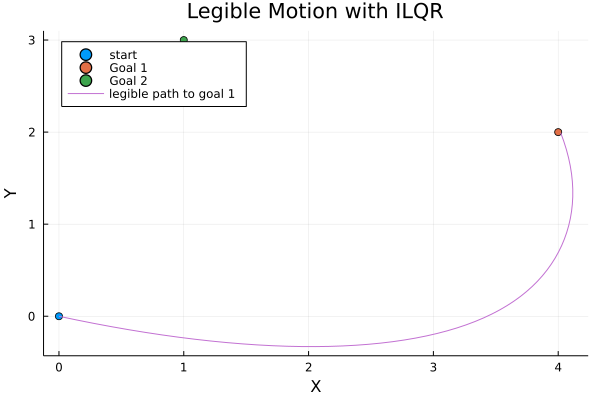

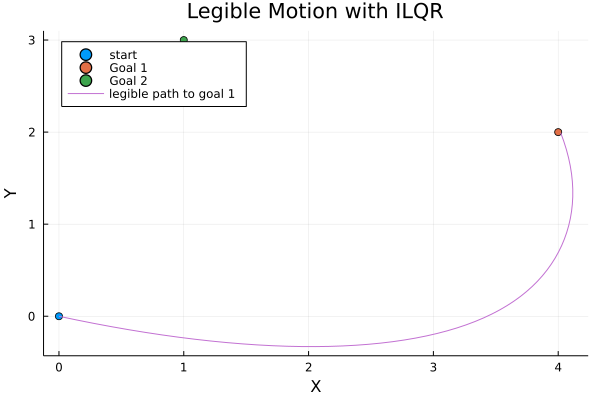

In [25]:
xvals_leg = [Xline[i][1] for i=1:N]
yvals_leg = [Xline[i][2] for i=1:N]


p = plot()
scatter!([start[1]], [start[2]], label="start")
for i=1:length(all_goals)
    goal = all_goals[i]
    scatter!([goal[1]], [goal[2]], label=string("Goal ", i) )
end

plot!(xvals_leg, yvals_leg, legend=:topleft, label="legible path to goal 1")

xlabel!("X")
ylabel!("Y")

title!("Legible Motion with ILQR")

